In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

# Preparing data

## Read the Data

In [18]:
df1 = pd.read_csv("data/train_data.csv")

## Number of Transactions

In [19]:
print("Number of rows = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['label'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['label'] == 0])))

Number of rows = 189628
Number of fradulent transactions = 276
Number of valid transactions = 189352


## Sample Data

In [20]:
df1.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


## Data Preprocessing

In [21]:
#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)


## Fradulent transactions per card id

In [22]:
df2 = df1[['card_id','label']].groupby(['card_id']).sum().sort_values(['label'], ascending=False)

print(f"Cards with frauds committed: {len(df2.loc[df2['label'] > 0])}")

df2.head()

Cards with frauds committed: 252


,label
card_id,
157140,4
41564,4
99562,3
128466,3
74739,2


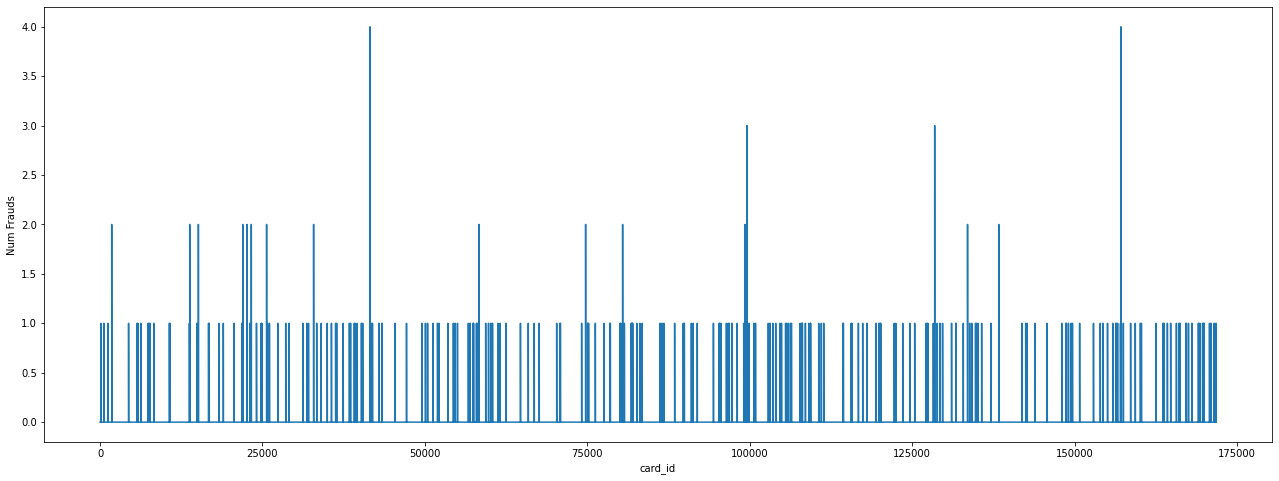

In [23]:
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df2.index,y=df2['label'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Fradulent transactions per IP

In [24]:
df3 = df1[['ip_id','label']].groupby(['ip_id']).sum().sort_values(['label'], ascending=False)

print(f"IPs with frauds committed: {len(df3.loc[df3['label'] > 0])}")

df3.head()

IPs with frauds committed: 251


,label
ip_id,
154455,5
150269,4
26491,3
152650,3
12537,3


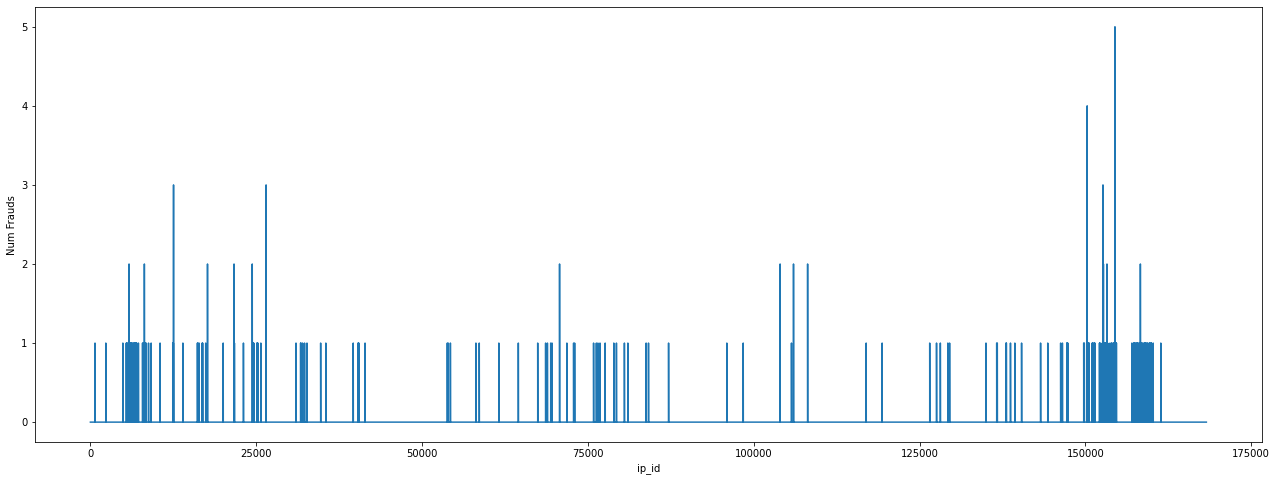

In [25]:
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df3.index,y=df3['label'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Data Preprocessing

In [26]:
def currency_to_eur(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']] * 100)

def process_data(df):
    # Prepare card id and ip id for plotting
    
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Cleaning the data
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    unique_issuer_cc = df['issuercountrycode'].unique()
    unique_shopper_cc = df['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df['issuercountrycode'] = enc.transform(df.issuercountrycode)
    df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
    df['amount_eur'] = df.apply(lambda x: currency_to_eur(x), axis=1)

    enc1 = LabelEncoder()
    enc1.fit(df['txvariantcode'])
    df['txvariantcode'] = enc1.transform(df.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df['currencycode'])
    df['currencycode'] = enc2.transform(df.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df['shopperinteraction'])
    df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    enc4 = LabelEncoder()
    enc4.fit(df['accountcode'])
    df['accountcode'] = enc4.transform(df.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df['cardverificationcodesupplied'])
    df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    return df[['issuercountrycode',
             'txvariantcode',
             'bin',
             'amount',
             'currencycode',
             'shoppercountrycode',
             'shopperinteraction',
             'cardverificationcodesupplied',
             'cvcresponsecode',
             'accountcode',
             'mail_id',
             'ip_id',
             'card_id',
             'amount_eur',
             'countries_equal']
    ]


In [27]:
df1 = pd.read_csv("data/train_data.csv")

X = process_data(df1)
X.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal
0,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,52.175123,1
1,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,39.363232,1
2,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,45.160467,1
3,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,177.917169,1
4,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,59.073834,1


## Heat Maps

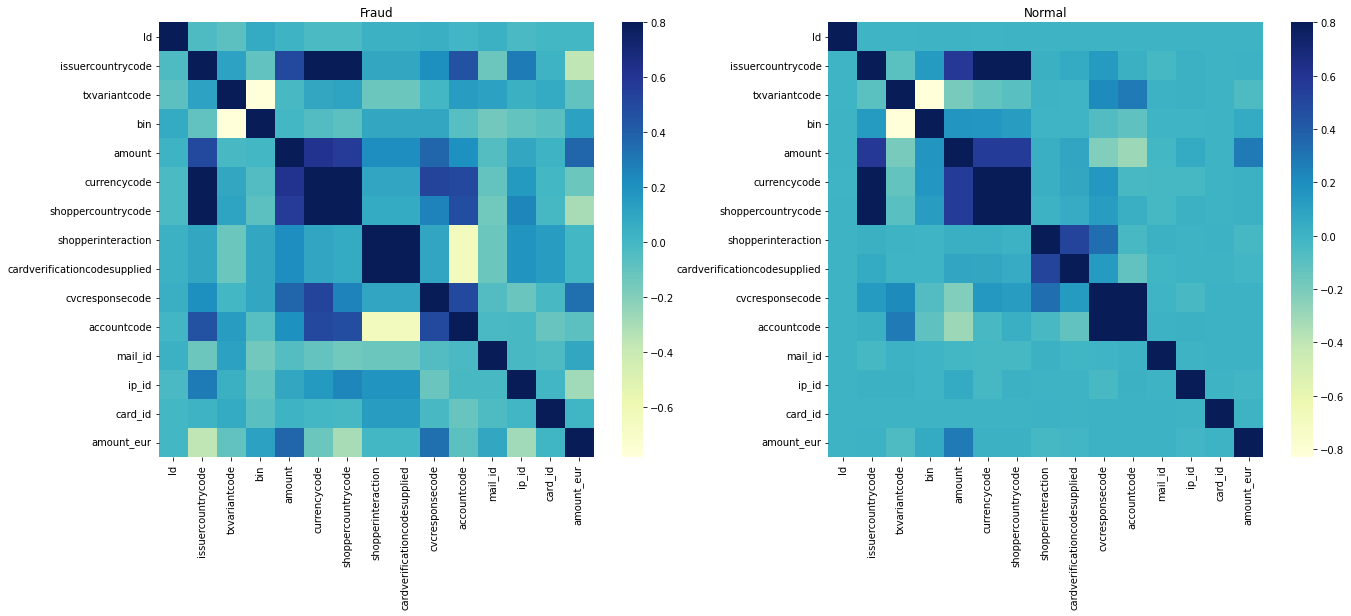

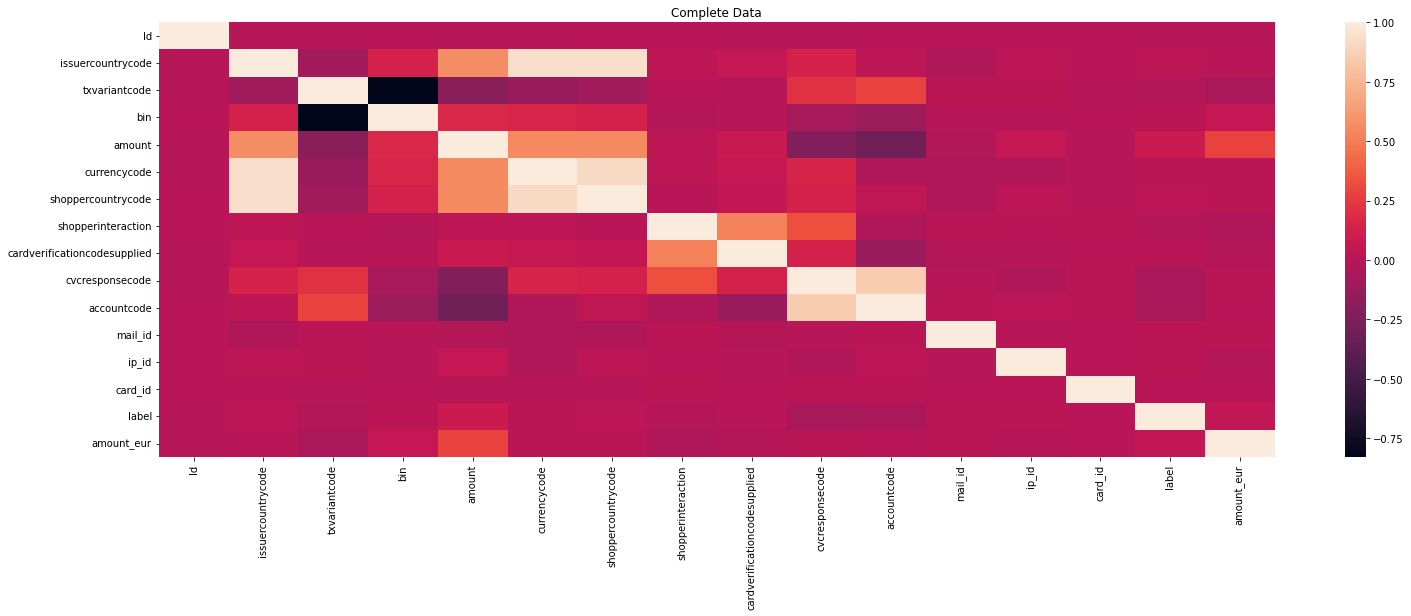

In [28]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

sns.heatmap(df1.query('label==1').drop('label', axis='columns').corr(), vmax=.8, square=True, ax=ax1, cmap='YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df1.query('label==0').drop('label', axis='columns').corr(), vmax=.8, square=True, ax=ax2, cmap='YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1, figsize=(25, 8))
sns.heatmap(df1.corr())
ax1.set_title('Complete Data')

plt.show()

# Applying machine learning

In [29]:
df = pd.read_csv("data/train_data.csv")

X = process_data(df.copy())
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(f"Benign cases in train set: {len(y_train[y_train == 0])}")
print(f"Benign cases in test set: {len(y_test[y_test == 0])}")
print(f"Fraudulent cases in train set: {len(y_train[y_train == 1])}")
print(f"Fraudulent cases in test set: {len(y_test[y_test == 1])}")

Benign cases in train set: 151485
Benign cases in test set: 37867
Fraudulent cases in train set: 217
Fraudulent cases in test set: 59


## Logistic regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.00      0.00      0.00        59

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84443389759005


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecatio

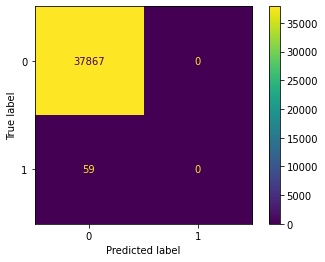

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

logreg_classifier = LogisticRegression(random_state=0)
logreg_classifier.fit(X_train, y_train)

y_predictions = logreg_classifier.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

plot_confusion_matrix(logreg_classifier, X_test, y_test)
plt.show()

## Random forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.00      0.00      0.00        59

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84443389759005


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecatio

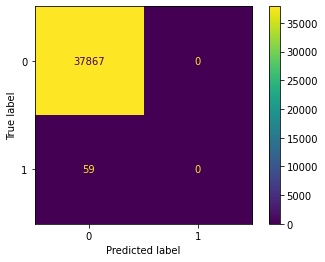

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(max_depth=2, random_state=0)
forest_classifier.fit(X_train, y_train)

y_predictions = forest_classifier.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

plot_confusion_matrix(forest_classifier, X_test, y_test)
plt.show()

## Decision tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.08      0.19      0.11        59

    accuracy                           1.00     37926
   macro avg       0.54      0.59      0.56     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.54648526077098


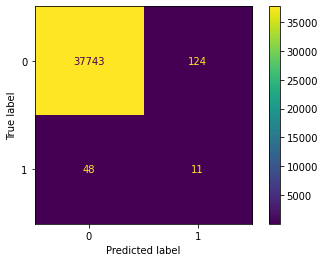

In [39]:
from sklearn.tree import DecisionTreeClassifier

dtree_classifier = DecisionTreeClassifier(random_state=0)
dtree_classifier.fit(X_train, y_train)

y_predictions = dtree_classifier.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

plot_confusion_matrix(dtree_classifier, X_test, y_test)
plt.show()

## Conclusions

Although the accuracy approaching 100% would be a good sign if classes were evenly distributed, in our case it's misleading since over 99% of the data set consists of entities of benign, while less than 1% is the remaining class of fraud transactions.
This leads to the classifiers becoming biased towards classifying all the transactions as benign ones.

Looking at precision and recall reveals that in case of logistic regression and random forest classifiers not a single fraud transaction was determined correctly in the test set.
In case of decision tree classifier the probability of successfully detecting a fraudulent case (recall) is low and revolves around 22%.
Also, among all the cases marked as fraudulent, only 18% were indeed fraudulent (precision of 18%).

This means that without additional tweaking and data set modifications, the aforementioned machine learning methods are not applicable for determining fraud. 


# Handling imbalanced data

## SMOTE

Author: Konrad Ponichtera

In order to rebalance the training data set, the real fraud transaction will be split to two sets.
One of them will be used for testing classifiers, while the other one will serve as a base for SMOTE.

In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from random import Random
import time

# Ignoring the FutureWarning which is internally thrown by NearestNeighbors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def smote(X, N=100, k=5, random_state=None):
    if random_state is not None:
        random = Random(random_state)
    else:
        random = Random()

    assert N >= 100
    N = N // 100
    
    column_names = X.columns
    new_samples = pd.DataFrame(columns=column_names)
    X = X.to_numpy()

    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)

    for x in X:
        nnarray = knn.kneighbors([x], k, return_distance=False)[0]
        
        # Populate
        for _ in range(N):
            nn = random.randrange(0, k)
            
            neighbor_item = X[nnarray[nn]]
            
            diff = neighbor_item - x
            gap = random.uniform(0, 1)
            new_item = x + gap * diff
            
            new_samples = pd.concat([new_samples, pd.DataFrame(new_item.reshape(1, -1), columns=column_names)])
        
    return new_samples

df = pd.read_csv("data/train_data.csv")

X = process_data(df.copy())
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(f"Benign cases in train set: {len(y_train[y_train == 0])}")
print(f"Benign cases in test set: {len(y_test[y_test == 0])}")
print(f"Fraudulent cases in train set: {len(y_train[y_train == 1])}")
print(f"Fraudulent cases in test set: {len(y_test[y_test == 1])}")

X_train_fraud = X_train.loc[y_train == 1]

start = time.time()
X_fraud_smote = smote(X_train_fraud.copy(), N=20000, random_state=0)
smote_time = time.time() - start

print(f"SMOTE ran for {smote_time} seconds and generated {len(X_fraud_smote)} synthetic samples")

X_train = pd.concat([X_train, X_fraud_smote])
y_train = pd.concat([
    y_train,
    pd.Series(1, index=range(len(X_fraud_smote)))
])

X_train, y_train = shuffle(X_train, y_train, random_state=0)

print(f"Benign cases in train set after SMOTE: {len(y_train[y_train == 0])}")
print(f"Fraudulent cases in train set after SMOTE: {len(y_train[y_train == 1])}")

X_fraud_smote.head()

Benign cases in train set: 151485
Benign cases in test set: 37867
Fraudulent cases in train set: 217
Fraudulent cases in test set: 59
SMOTE ran for 203.71467232704163 seconds and generated 43400 synthetic samples
Benign cases in train set after SMOTE: 151485
Fraudulent cases in train set after SMOTE: 43617


,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal
0,100.0,6.0,434017.867227,188454.888516,2.0,100.0,1.0,1.0,0.0,1.0,163420.747119,157298.368689,48254.56435,88.547561,1.0
0,100.0,6.0,474979.665881,199288.685889,2.0,100.0,1.0,1.0,0.0,1.0,166081.843441,154130.73853,23241.406877,93.637937,1.0
0,100.0,7.943711,477253.583567,187606.029277,2.0,100.0,1.0,1.0,0.0,1.0,153818.491064,156092.997431,55448.421759,88.148715,1.0
0,100.0,6.0,456245.22131,170769.220153,2.0,100.0,1.0,1.0,0.0,1.0,133478.744772,153219.375404,41093.091099,80.237759,1.0
0,100.0,6.0,464604.77417,182340.200612,2.0,100.0,1.0,1.0,0.0,1.0,146488.601639,153510.379796,33441.636113,85.674509,1.0


# Applying machine learning to synthetic data

## Logistic regression

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     37867
           1       0.02      0.53      0.04        59

    accuracy                           0.96     37926
   macro avg       0.51      0.74      0.51     37926
weighted avg       1.00      0.96      0.98     37926

Accuracy: 96.31651110056426


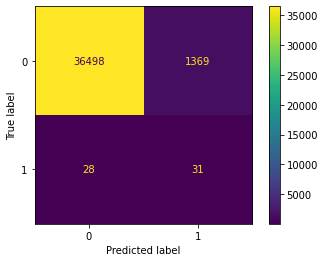

In [40]:
from sklearn.metrics import roc_curve, auc

logreg_classifier = LogisticRegression(random_state=0)
logreg_classifier.fit(X_train, y_train)

y_predictions = logreg_classifier.predict(X_test)
y_predictions_proba = logreg_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

y_score = logreg_classifier.decision_function(X_test)

logreg_fpr, logreg_tpr, _ = roc_curve(y_test, y_predictions_proba)
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)

plot_confusion_matrix(logreg_classifier, X_test, y_test)
plt.show()

## Random forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.20      0.17      0.18        59

    accuracy                           1.00     37926
   macro avg       0.60      0.58      0.59     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.76269577598481


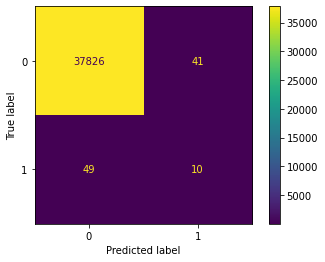

In [41]:
forest_classifier = RandomForestClassifier(random_state=0)
forest_classifier.fit(X_train, y_train)

y_predictions = forest_classifier.predict(X_test)
y_predictions_proba = forest_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

forest_fpr, forest_tpr, _ = roc_curve(y_test, y_predictions_proba)
forest_roc_auc = auc(forest_fpr, forest_tpr)

plot_confusion_matrix(forest_classifier, X_test, y_test)
plt.show()

## Decision tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.08      0.19      0.11        59

    accuracy                           1.00     37926
   macro avg       0.54      0.59      0.56     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.54648526077098


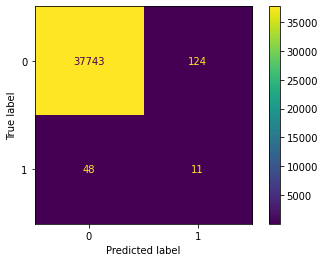

In [43]:
dtree_classifier = DecisionTreeClassifier(random_state=0)
dtree_classifier.fit(X_train, y_train)

y_predictions = dtree_classifier.predict(X_test)
y_predictions_prob = dtree_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

dtree_fpr, dtree_tpr, _ = roc_curve(y_test, y_predictions_prob)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

plot_confusion_matrix(dtree_classifier, X_test, y_test)
plt.show()

## Comparison

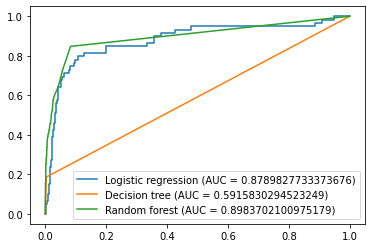

In [38]:
plt.figure(0).clf()
plt.plot(logreg_fpr, logreg_tpr, label=f"Logistic regression (AUC = {logreg_roc_auc})")
plt.plot(dtree_fpr, dtree_tpr, label=f"Decision tree (AUC = {dtree_roc_auc})")
plt.plot(forest_fpr, forest_tpr, label=f"Random forest (AUC = {forest_roc_auc})")
plt.legend()
plt.show()

## Conclusions

Although all of the used machine learning methods performed poorly when used with the original data set, using SMOTE to generate synthetic instances of the minority class drastically increased the precision and recall of the classifiers when used to detect frauds.

All classifiers managed to correctly classify all the benign transactions.
Logistic regression managed to misclassify little amount of benign transaction as fraudulent ones (99% precision), but it also managed to detect all the actual fraudulent transactions (100% recall).
On the other hand, random forest didn't mark any benign transaction as fradulent (100% precision), but managed to miss some fraudulent transactions and classify them as benign (99% recall).
Although decision tree seemed to perform better than the other classifiers when used with the unbalanced data set, its performance is now slightly worse than the one of logistic regression and random forest classifiers.
It both misclassified some benign transactions as fraudulent (98% precision) and missed several fraudulent ones (95% recall).

In conclusion, SMOTE is extremely effective in dealing with imbalanced data.

# Classification

In [44]:
from imblearn.over_sampling import SMOTE

df = pd.read_csv("data/train_data.csv")

X = process_data(df.copy())
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

print(f"Benign cases in train set: {len(y_train[y_train == 0])}")
print(f"Benign cases in test set: {len(y_test[y_test == 0])}")
print(f"Fraudulent cases in train set: {len(y_train[y_train == 1])}")
print(f"Fraudulent cases in test set: {len(y_test[y_test == 1])}")

smote = SMOTE(random_state=0, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Benign cases in train set after SMOTE: {len(y_train[y_train == 0])}")
print(f"Fraudulent cases in train set after SMOTE: {len(y_train[y_train == 1])}")

Benign cases in train set: 151485
Benign cases in test set: 37867
Fraudulent cases in train set: 217
Fraudulent cases in test set: 59
Benign cases in train set after SMOTE: 151485
Fraudulent cases in train set after SMOTE: 151485


In [112]:
from sklearn.model_selection import KFold, cross_validate


def k_fold_validation(X, y, model, scoring='precision', fold_count=10):
    cv = KFold(n_splits=fold_count, random_state=0, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    max_score_index = np.argmax(scores['test_score'])
    
    return scores['estimator'][max_score_index]

## Whitebox classifier - decision tree

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     37867
           1       0.01      0.80      0.03        59

    accuracy                           0.91     37926
   macro avg       0.51      0.85      0.49     37926
weighted avg       1.00      0.91      0.95     37926

Accuracy: 91.10372831303064


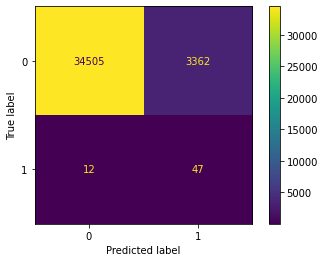

In [137]:
from sklearn.model_selection import cross_val_score, cross_val_predict

dtree_classifier = DecisionTreeClassifier(max_depth=2, random_state=0)
dtree_classifier = k_fold_validation(X_train, y_train, dtree_classifier)

y_predictions = dtree_classifier.predict(X_test)
y_predictions_proba = dtree_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

dtree_fpr, dtree_tpr, _ = roc_curve(y_test, y_predictions_proba)
dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

plot_confusion_matrix(dtree_classifier, X_test, y_test)
plt.show()

### Explaining the whitebox classifier

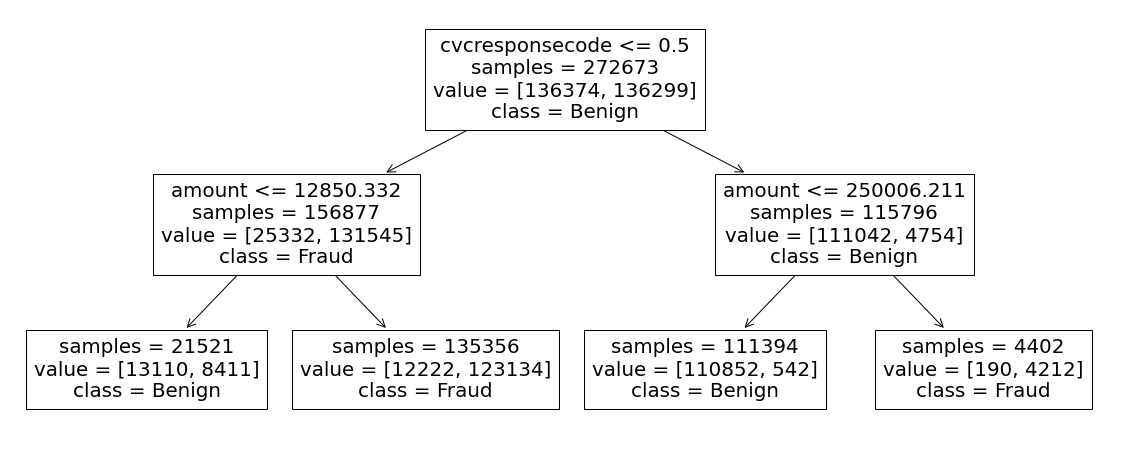

Example transaction, classified as fraud:
issuercountrycode                       49
txvariantcode                            3
bin                               532916.0
amount                             38614.0
currencycode                             1
shoppercountrycode                      49
shopperinteraction                       1
cardverificationcodesupplied             0
cvcresponsecode                          1
accountcode                              3
mail_id                              36936
ip_id                                14117
card_id                             106840
amount_eur                      447.708932
countries_equal                          1
predicted_label                          0
Name: 71148, dtype: object


In [154]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 8))
plot_tree(dtree_classifier, feature_names=X_train.columns, class_names=['Benign', 'Fraud'], impurity=False)
plt.show()

X_test_withpredictions = X_test.copy()
X_test_withpredictions['predicted_label'] = y_predictions
X_test_withpredictions.query('predicted_label==1')
predicted_fraud = X_test_withpredictions.iloc[0]

print("Example transaction, classified as fraud:")
print(predicted_fraud)

## Blackbox classifier - AdaBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.22      0.19      0.20        59

    accuracy                           1.00     37926
   macro avg       0.61      0.59      0.60     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.77060591678531


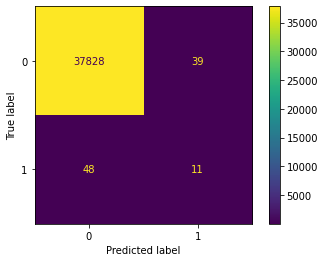

In [157]:
from sklearn.ensemble import AdaBoostClassifier

forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)

adaboost_classifier = AdaBoostClassifier(base_estimator=forest_classifier, random_state=0, n_estimators=20)
adaboost_classifier = k_fold_validation(X_train, y_train, adaboost_classifier)

y_predictions = adaboost_classifier.predict(X_test)
y_predictions_proba = adaboost_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, y_predictions_proba)
adaboost_roc_auc = auc(adaboost_fpr, adaboost_tpr)

plot_confusion_matrix(adaboost_classifier, X_test, y_test)
plt.show()

## Comparison

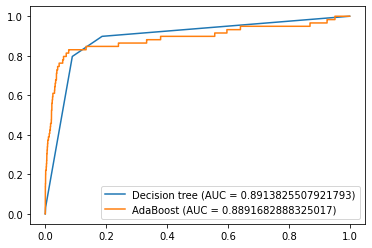

In [159]:
plt.figure(0).clf()
plt.plot(dtree_fpr, dtree_tpr, label=f"Decision tree (AUC = {dtree_roc_auc})")
plt.plot(adaboost_fpr, adaboost_tpr, label=f"AdaBoost (AUC = {adaboost_roc_auc})")
plt.legend()
plt.show()

## Using best classifier for Kaggle competition

In [160]:
df_kaggle = pd.read_csv("data/test_data.csv")
df_kaggle_processed = process_data(df_kaggle.copy())

clf = adaboost_classifier

y_predictions = clf.predict_proba(df_kaggle_processed)

df_submission = pd.DataFrame({'Id': df_kaggle['Id'], 'Predicted': y_predictions[:, 1]})
df_submission.to_csv("submission.csv", index=False)